## Analysis
In this analysis, a resnet18 model is used to train over chest xray images to predict covid-19
The normal images are sampled from the kaggle chest xray images. 

In [38]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dataset_name', type=str, default='COVID19_ChestXray_MultiLabel') # required
parser.add_argument('--model_name', type=str, default='resnet50') #required
parser.add_argument('--result_path', type=str, default='result', help='output path')
parser.add_argument('--data_path', type=str, default='dataset_partition', help='path for data partition')

# Training
parser.add_argument('--num_epochs', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--lr', type=float, default=5e-5)
parser.add_argument('-e', '--lr_decay', type=float, default=0.995,
                    help='Learning rate decay, applied every step of the optimization')
parser.add_argument('--seed', type=int, default=1,
                    help='Random seed to use')
parser.add_argument('--log_step', type=int, default=100, help='step size for prining log info')
parser.add_argument('--save_step', type=int, default=20, help='step size for saving trained models')

parser.add_argument('--flag_retrain', default=False, action='store_true', help='Re train')
parser.add_argument('--flag_reg', default=False, action='store_true', help='Regularizer')
parser.add_argument('--flag_plot', default=False, action='store_true', help='Plot')
parser.add_argument('--img_size', type=int, default=256)

# Model parameters
args = parser.parse_args("")

In [39]:
import os, sys, time, shutil
import numpy as np
import importlib
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils
import torchvision
import pdb

device=torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Arguments
model_name=args.model_name + '-' + args.dataset_name
dataset_path=os.path.join(args.data_path, args.dataset_name)
output_path=os.path.join(args.result_path, model_name)

# saved checkpoint
model_path=os.path.join(output_path, 'snapshots')
net_path=os.path.join(model_path, 'net.pth')
adv_path = os.path.join(model_path, 'adv.pth')
sample_path=os.path.join(output_path, 'samples')
log_path=os.path.join(output_path, "log.txt")
run_path = os.path.join(output_path, 'runs')

params_str = 'debug'
writer_path=os.path.join(run_path, params_str) 

# makedir
def make_dir(dirname, rm=False):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    elif rm:
        print('rm and mkdir ', dirname)
        shutil.rmtree(dirname)
        os.makedirs(dirname)

make_dir(args.result_path)
make_dir(output_path)
make_dir(model_path)
make_dir(sample_path)
make_dir(run_path)
logf=open(log_path, 'w')
make_dir(writer_path, rm=False)
writer=SummaryWriter(comment=model_name, log_dir=writer_path)

In [3]:
import datasets
importlib.reload(datasets)

<module 'datasets' from '/home/aka/Experiments/covid/covid-analysis/datasets.py'>

In [20]:
# Logging helper functions 
def log_loss(epoch, step, total_step, loss, start_time):
    # convert
    loss=loss.cpu().data.numpy()
    # msg
    message='Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, time: {:.4f}s'.format(
        epoch, args.num_epochs, step, total_step, loss, time.time() - start_time)
    # log out
    logf.write(message + '\n')
    print(message)
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
class SingleChannel(object):
    def __call__(self, img):
        img = img[0,:,:].unsqueeze(0)
        return img

train_transform = transforms.Compose([transforms.Resize(args.img_size + 24), 
                                      transforms.RandomRotation(10),
                                      transforms.CenterCrop(args.img_size),
                                      transforms.ToTensor(),
                                      SingleChannel()])
test_transform = transforms.Compose([transforms.Resize(args.img_size + 24), 
                                     transforms.CenterCrop(args.img_size),
                                     transforms.ToTensor(),
                                     SingleChannel()])
trainset = datasets.COVID19_ChestXray_Merged_Dataset(dataset_partition=args.data_path, train=True, 
                                                    transform=train_transform, multilabel=True, full=True)
testset = datasets.COVID19_ChestXray_Merged_Dataset(dataset_partition=args.data_path, train=False, 
                                                    transform=test_transform, multilabel=True, full=True)
trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=args.batch_size, shuffle=False)

['covid', 'normal', 'viral', 'bacterial']
torch.Size([1, 256, 256]) tensor([1., 0., 0., 0.])


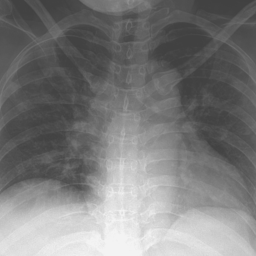

torch.Size([1, 256, 256]) tensor([1., 0., 0., 0.])


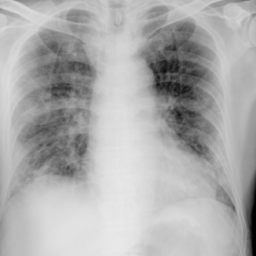

torch.Size([1, 256, 256]) tensor([1., 0., 0., 0.])


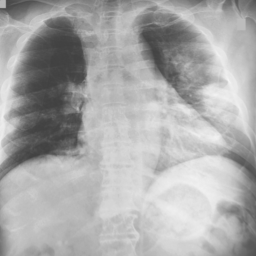

torch.Size([1, 256, 256]) tensor([1., 0., 0., 0.])


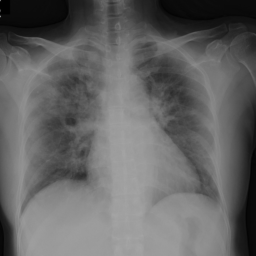

torch.Size([1, 256, 256]) tensor([1., 0., 0., 0.])


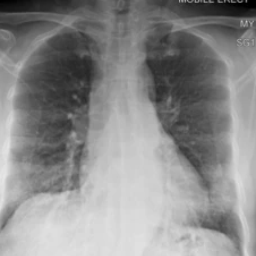

In [6]:
print(testset.get_keys())
for i in range(5):
    img, label = testset.__getitem__(i)
    print(img.shape, label)
    display(transforms.ToPILImage()(img))

In [4]:
import model as mymodel
importlib.reload(mymodel)

<module 'model' from '/home/aka/Experiments/covid/covid-analysis/model.py'>

In [201]:
def initialize_using_pretrained(resnet):
    pretrained_resnet = torchvision.models.resnet50(pretrained=True)
    resnet.layer1.load_state_dict(pretrained_resnet.layer1.state_dict())
    resnet.layer2.load_state_dict(pretrained_resnet.layer2.state_dict())
    resnet.layer3.load_state_dict(pretrained_resnet.layer3.state_dict())
    resnet.layer4.load_state_dict(pretrained_resnet.layer4.state_dict())

In [202]:
resnet = mymodel.resnet50(num_classes=4)
initialize_using_pretrained(resnet)
resnet = resnet.to(device)

In [203]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=args.lr)
lmbda = lambda epoch: 1.0 if epoch < 10 else 0.5
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=[lmbda])

In [204]:
def write_accuracy(epoch, classes, correct, total, writer, tag):
    total_accuracy = correct.sum()*100.0 / total.sum()
    writer.add_scalar('Total accuracy/' + tag, total_accuracy.item(), epoch)
    print(tag, 'total accuracy ', total_accuracy.item())
    for cls, c, t in zip(classes, correct, total):
        precision = c*100.0/t
        writer.add_scalar(cls + '/' + tag, precision, epoch)
        print(tag, cls, 'precision', precision)

def log_barrier_extn(z, t):
    if t*t*z + 1 <= 0:
        return -torch.log(-z)/t
    else:
        return t*z + 2.0*math.log(t)/t + 1.0/t
        
def lbarrier_loss(labels, pred, classes):
    covid_cls = np.where(classes == 'covid')[0]
    pred = pred[labels == covid_cls]
    pred_labels = torch.argsmax(pred, 1)
    pred = pred[pred_labels != covid_cls]
    if pred.size(0) == 0:
        return 0
    # lbarrier constraint on these predictions
    err_approx = torch.sigmoid(pred - pred.mean(dim=1))
    err_approx[covid_cls] = 0
    total_err_approx = err_approx.sum(0).mean()
    threshold = 0.001
    loss = log_barrier_extn(total_err_approx - threshold, t=1)
        
def train_epoch(epoch, model, optimizer, dataloader, writer):
    model.train()
    start_time = time.time()
    loss_logger = AverageMeter()
    total_step = len(dataloader.dataset)//args.batch_size
    
    classes = np.array(dataloader.dataset.get_keys())
    num_classes = classes.shape[0]
    correct = torch.zeros(num_classes).to(device)
    total = torch.zeros_like(correct)
    
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)  # These are one hot encoding
        labels = torch.argmax(labels, 1)
        pred = model(images)
        pred_labels = torch.argmax(pred, 1)
        
        for i in range(pred.size(1)):
            class_pred_labels = pred_labels[labels == i]
            correct[i] += torch.sum(class_pred_labels == i)
            total[i] += class_pred_labels.size(0)
        
        #pdb.set_trace()
        loss = F.cross_entropy(pred, labels)
        loss_logger.update(loss.item())
        
        if idx % args.log_step == 0:
            log_loss(epoch, idx, total_step, loss, start_time)
            start_time = time.time()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    writer.add_scalar('Loss/train', loss_logger.avg, epoch)
    write_accuracy(epoch, classes, correct, total, writer, 'train')

def test_epoch(epoch, model, dataloader, writer):
    model.eval()
    loss_logger = AverageMeter()
    
    classes = np.array(dataloader.dataset.get_keys())
    num_classes = classes.shape[0]
    correct = torch.zeros(num_classes).to(device)
    total = torch.zeros_like(correct)
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, 1)
        pred = model(images)
        pred_labels = torch.argmax(pred, 1)
        
        for i in range(pred.size(1)):
            class_pred_labels = pred_labels[labels == i]
            correct[i] += torch.sum(class_pred_labels == i)
            total[i] += class_pred_labels.size(0)
        
        loss = F.cross_entropy(pred, labels)
        loss_logger.update(loss.item())
    writer.add_scalar('Loss/test', loss_logger.avg, epoch)
    write_accuracy(epoch, classes, correct, total, writer, 'test')
        
def train(model, optimizer, scheduler, trainloader, testloader, writer):
    for epoch in range(args.num_epochs):
        train_epoch(epoch, model, optimizer, trainloader, writer)
        test_epoch(epoch, model, testloader, writer)
        scheduler.step()
    print('Saving the model')
    torch.save(model.state_dict(), net_path)

In [205]:
train(resnet, optimizer, scheduler, trainloader, testloader, writer)

Epoch [0/15], Step [0/659], Loss: 1.5745, time: 0.1342s
Epoch [0/15], Step [100/659], Loss: 0.2716, time: 20.6147s
Epoch [0/15], Step [200/659], Loss: 0.4376, time: 19.7230s
Epoch [0/15], Step [300/659], Loss: 0.4825, time: 20.2934s
Epoch [0/15], Step [400/659], Loss: 1.6440, time: 20.6258s
Epoch [0/15], Step [500/659], Loss: 0.6994, time: 22.5731s
Epoch [0/15], Step [600/659], Loss: 0.4798, time: 20.0368s
train total accuracy  73.48369598388672
train covid precision tensor(3.3333, device='cuda:1')
train normal precision tensor(91.2006, device='cuda:1')
train viral precision tensor(39.3309, device='cuda:1')
train bacterial precision tensor(83.9130, device='cuda:1')
test total accuracy  80.15625
test covid precision tensor(87.5000, device='cuda:1')
test normal precision tensor(65.3846, device='cuda:1')
test viral precision tensor(76.3513, device='cuda:1')
test bacterial precision tensor(96.2810, device='cuda:1')
Epoch [1/15], Step [0/659], Loss: 0.4295, time: 0.1973s
Epoch [1/15], Step 

Epoch [9/15], Step [100/659], Loss: 0.4829, time: 20.8638s
Epoch [9/15], Step [200/659], Loss: 0.0559, time: 20.6125s
Epoch [9/15], Step [300/659], Loss: 0.3097, time: 20.3296s
Epoch [9/15], Step [400/659], Loss: 0.6485, time: 19.4904s
Epoch [9/15], Step [500/659], Loss: 0.5774, time: 19.6330s
Epoch [9/15], Step [600/659], Loss: 0.2385, time: 20.2744s
train total accuracy  91.26232147216797
train covid precision tensor(96.6667, device='cuda:1')
train normal precision tensor(98.8069, device='cuda:1')
train viral precision tensor(81.8587, device='cuda:1')
train bacterial precision tensor(92.1344, device='cuda:1')
test total accuracy  74.84375
test covid precision tensor(100., device='cuda:1')
test normal precision tensor(56.8376, device='cuda:1')
test viral precision tensor(78.3784, device='cuda:1')
test bacterial precision tensor(88.4297, device='cuda:1')
Epoch [10/15], Step [0/659], Loss: 0.0843, time: 0.1286s
Epoch [10/15], Step [600/659], Loss: 0.0929, time: 21.3669s
train total accu

For setting of lr=1e-4, batch size=8, epochs=50

## Insights
We can visualize on what the model focusses on from this data using CAM.

In [6]:
import cv2
from matplotlib import rcParams
rcParams['figure.figsize'] = 16,16
import matplotlib.cm as cm
import cam
importlib.reload(cam)
from gradcam.grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

In [41]:
# Reload the model from the saved snapshot
model = mymodel.resnet50(num_classes=4).to(device)
model.load_state_dict(torch.load(net_path))

<All keys matched successfully>

### Grad-CAM
Based on https://github.com/kazuto1011/grad-cam-pytorch#demo-1

In [40]:
def get_act_map(gradient):
    gradient = gradient.cpu()
    gradient -= gradient.min()
    gradient /= gradient.max()
    return gradient

In [42]:
def generate_guided_gradcam(model, dataloader):
    classes = np.array(dataloader.dataset.get_keys())
    print(classes)
    count = torch.zeros(classes.shape[0])
    maxcount = 10
    rcParams['figure.figsize'] = 16,16
    def show_cams(image, regions, gradients):
        image = image.cpu()
        act_map = get_act_map(torch.mul(regions, gradients))
        gcam_map = cam.apply_colormap_on_image(to_image(image), np.uint8(regions.squeeze().cpu().numpy()*255))
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(to_image(image), cmap='gray')
        ax[2].imshow(to_image(act_map), cmap='gray')
        ax[1].imshow(gcam_map)
        plt.show()
    
    model.eval()
    to_image = transforms.ToPILImage()
    
    for images, labels in dataloader:
        images = images.to(device)
        pred = model(images)
        labels = labels.to(device)
        labels = torch.argmax(labels, 1)
        pred_labels = torch.argmax(pred, 1)
        if (pred_labels == 0).sum == 0 or (labels == 0).sum() == 0:
            continue
        
        # For each covid-19 positive chest-xray we try to see the regions used according to gradcam
        gcam = GradCAM(model=model)
        _ = gcam.forward(images)
        gbp = GuidedBackPropagation(model=model)
        _ = gbp.forward(images)
        ids = labels.unsqueeze(1)
        # Gradient
        gbp.backward(ids=ids)
        gradients = gbp.generate()

        # Grad-CAM
        gcam.backward(ids=ids)
        regions = gcam.generate(target_layer="layer4")  # For resent the target layer is layer4

        # Show the activation maps
        for i in range(len(images)):
            j, cls = labels[i].item(), classes[labels[i].item()]
            count[j] += 1
            if count[j] <= maxcount or cls is 'covid':
                print(cls)
                show_cams(images[i], regions[i], gradients[i])
            break

['covid' 'normal' 'viral' 'bacterial']
covid


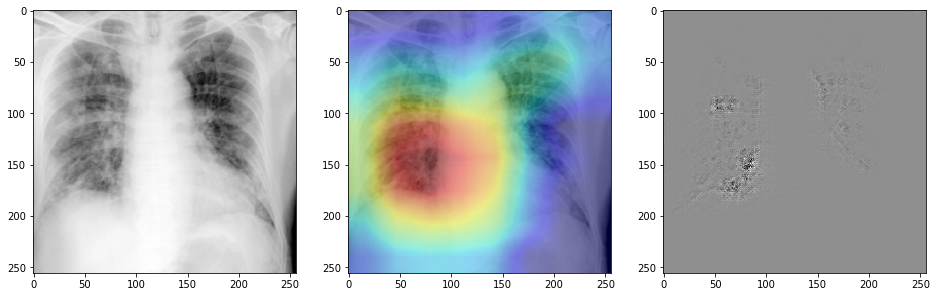

covid


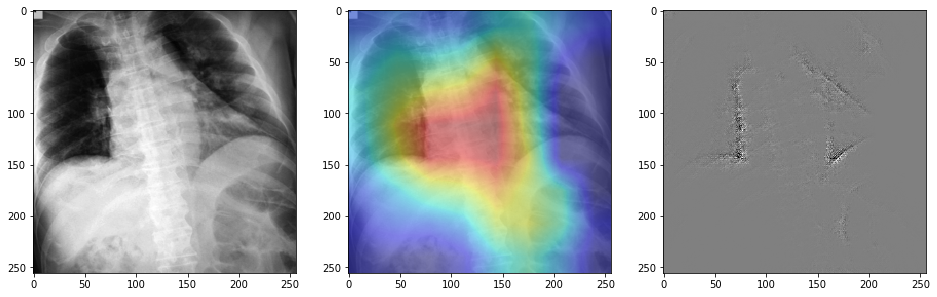

covid


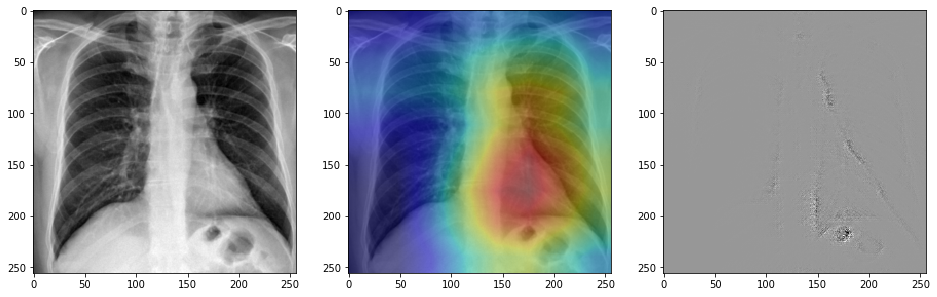

covid


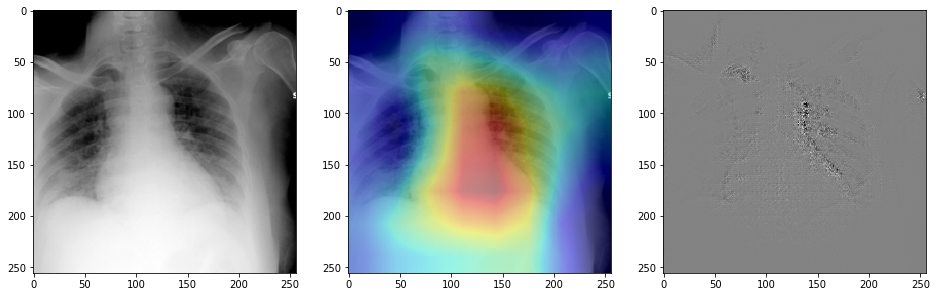

covid


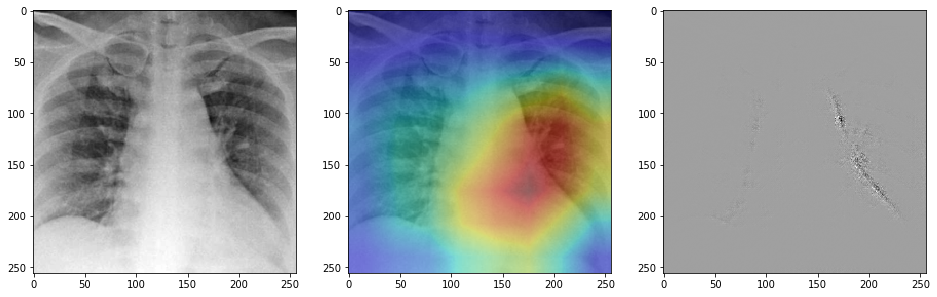

covid


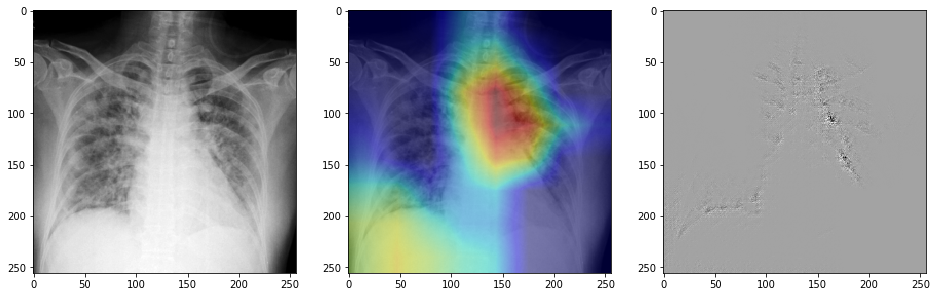

covid


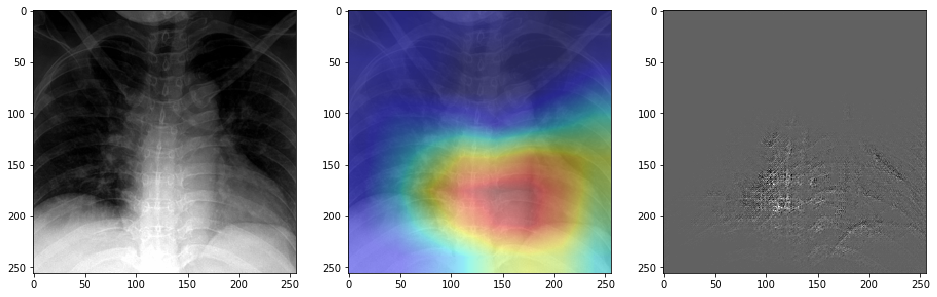

covid


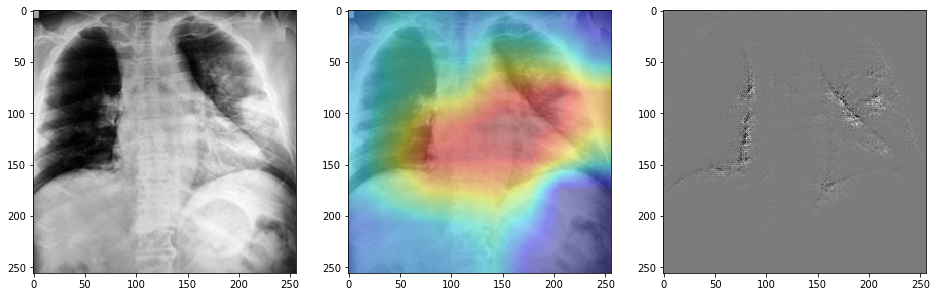

covid


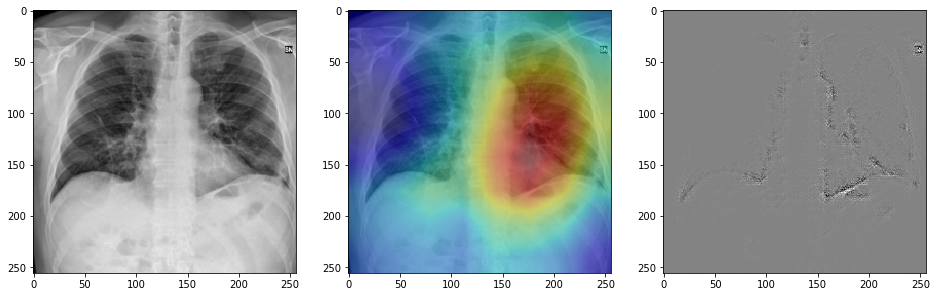

covid


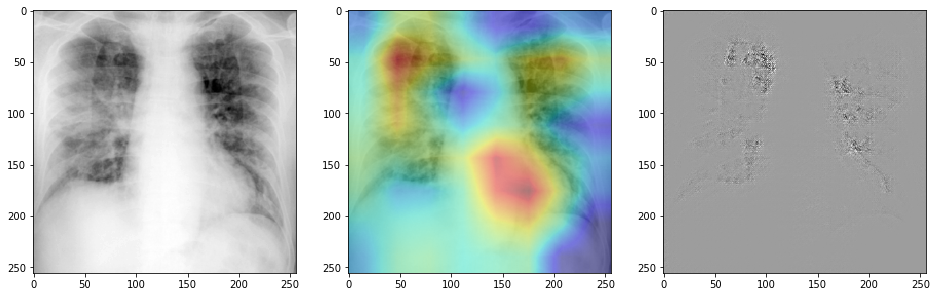

In [43]:
genloader = DataLoader(testset, batch_size=1, shuffle=True)
generate_guided_gradcam(model, genloader)

In the above heatmaps, we plot grad-cam and guided-gradcam for the cases in which model predicts covid correctly. Guided-gradcam provides more granularity over pixels affecting the model prediction. The gradcam images are up for interpretation.